In [1]:
import tensorflow as tf
import os
from model import unet_model
from keras.utils import normalize
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
import csv
import pandas as pd

### **1. Initial Setup**

#### **1.1 Configurations**

In [2]:
# Read an sample to get correct configuration
path = "../data/Sandstone/masks/mask_0000.png"
img = cv2.imread(path, cv2.IMREAD_COLOR)
h, w, c = img.shape

In [3]:
np.unique(img)

array([0, 1, 2, 3], dtype=uint8)

In [4]:
# Configuration
colors = [[0, 0, 0], [0, 153, 255], [102, 255, 153], [0, 204, 153]]
cf = {}
cf['n'] = 4
cf['h'] = 256
cf['w'] = 256
cf['c'] = 1
cf['p'] =  16
cf['n_patches'] = (cf['h']  * cf['w']) // (cf['p'] * cf['p'])
cf['dropout'] =  0.1
cf['flat_p_shape'] = (
    cf['n_patches'],
    cf['p'] * cf['p'] * cf['c'],
    1
)

#### **1.2 Input pipeline**

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)    

class InputPipeline:
    def __init__(self, cf, path):
        self.cf = cf
        self.path = path
        self.load_dataset()
        
    def split_dataset(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.images, self.masks, test_size=0.2, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_val, self.y_val, test_size=0.5, random_state=42)
        print(
            len(self.X_train), len(self.y_train), 
            len(self.X_val), len(self.y_val),
            len(self.X_test), len(self.y_test)     
        )
        
    def load_dataset(self):
        self.images = sorted(glob(os.path.join(self.path, "images", "*.png")))
        self.masks = sorted(glob(os.path.join(self.path, "masks", "*.png")))
        self.split_dataset()
        
    def read_image(self, path):
        path = path.decode()
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (self.cf["h"], self.cf["w"]))
        image = image / 255.0

        patch_shape = (self.cf["p"], self.cf["p"], self.cf["c"])                     
        patches = patchify(image, patch_shape, self.cf["p"])                          
        patches = np.reshape(patches, self.cf["flat_p_shape"]).astype(np.float32)   
        return patches

    def read_mask(self, path):
        path = path.decode()
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.cf["h"], self.cf["w"])).astype(np.int32)
        return mask
    
    def tf_parse(self, x, y):
        def _parse(x, y):
            x = self.read_image(x)
            y = self.read_mask(y)
            y = tf.one_hot(y, cf["n"])
            return x, y

        x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
        x.set_shape(cf["flat_p_shape"])
        y.set_shape([cf["h"], cf["w"], cf["n"]])
        return x, y
            
    def tf_dataset(self, batch=2):
        self.train_ds = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        self.train_ds = self.train_ds.map(self.tf_parse).batch(batch).prefetch(10)
        
        self.val_ds = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
        self.val_ds = self.val_ds.map(self.tf_parse).batch(batch).prefetch(10)
        
        self.test_ds = tf.data.Dataset.from_tensor_slices((self.X_test, self.y_test))
        self.test_ds = self.test_ds.map(self.tf_parse).batch(batch).prefetch(10)
        
        return self.train_ds, self.val_ds, self.test_ds

In [6]:
dataset_path = "../data/Sandstone/"
ippl = InputPipeline(cf, dataset_path)
train_ds, val_ds, test_ds = ippl.tf_dataset()
print(train_ds)
print(val_ds)
print(test_ds)

204 204 26 26 26 26
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))>


In [7]:
print(tf.data.Dataset.cardinality(train_ds))
print(tf.data.Dataset.cardinality(val_ds))
print(tf.data.Dataset.cardinality(test_ds))

tf.Tensor(102, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)


In [8]:
for train_img, label_img in train_ds:
    print(train_img.numpy().shape, label_img.numpy().shape)
    print(np.unique(label_img.numpy()))
    break

(2, 256, 256, 1) (2, 256, 256, 4)
[0. 1.]


### **2. Model training**

#### **2.1 Model architecture**

In [82]:
model = unet_model(cf)
model.compile(
    loss="categorical_crossentropy", 
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

#### **2.2 Model fitting**

In [83]:
history = model.fit(
    train_ds,
    verbose=1, 
    epochs=30, 
    validation_data=val_ds, 
    shuffle=False
)

Epoch 1/30


102/102 [==============================] - 7s 51ms/step - loss: 0.6723 - accuracy: 0.8088 - val_loss: 0.6291 - val_accuracy: 0.8249
Epoch 2/30
102/102 [==============================] - 5s 45ms/step - loss: 0.6204 - accuracy: 0.8238 - val_loss: 0.6078 - val_accuracy: 0.8249
Epoch 3/30
102/102 [==============================] - 4s 43ms/step - loss: 0.6012 - accuracy: 0.8235 - val_loss: 0.5788 - val_accuracy: 0.8252
Epoch 4/30
102/102 [==============================] - 4s 43ms/step - loss: 0.5710 - accuracy: 0.8245 - val_loss: 0.5500 - val_accuracy: 0.8316
Epoch 5/30
102/102 [==============================] - 4s 43ms/step - loss: 0.5257 - accuracy: 0.8331 - val_loss: 0.4929 - val_accuracy: 0.8446
Epoch 6/30
102/102 [==============================] - 4s 43ms/step - loss: 0.4929 - accuracy: 0.8402 - val_loss: 0.4594 - val_accuracy: 0.8522
Epoch 7/30
102/102 [==============================] - 4s 43ms/step - loss: 0.4624 - accuracy: 0.8470 - val_loss: 0.4331 - val_accuracy: 0.8567
Epoch 8/30

#### **2.3 Save models and results**

In [84]:
# Extracting the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the file name
file_name = f'../results/unet_sandstone_30_ce_inp.csv'

# Writing the data into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
    for epoch in range(len(train_accuracy)):
        writer.writerow([epoch+1, train_accuracy[epoch], val_accuracy[epoch], train_loss[epoch], val_loss[epoch]])

print(f"Training history has been saved to {file_name}")

Training history has been saved to ../results/unet_sandstone_30_ce_inp.csv


In [85]:
model.save('../models/unet_sandstone_30_ce_inp.hdf5')   # architectyre_dataset_epochs

### **3. Visualization**

In [3]:
def read_output(option_csv=False):
    # Read from saved .csv file from results directory
    if option_csv==True:
        df = pd.read_csv('../results/unet_sandstone_30_ce_inp.csv')
        return df['Train Loss'].tolist(), df['Val Loss'].tolist(), df['Train Accuracy'].tolist(), df['Val Accuracy'].tolist()
    
    # Use from tensorflow history
    else:
        return history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']

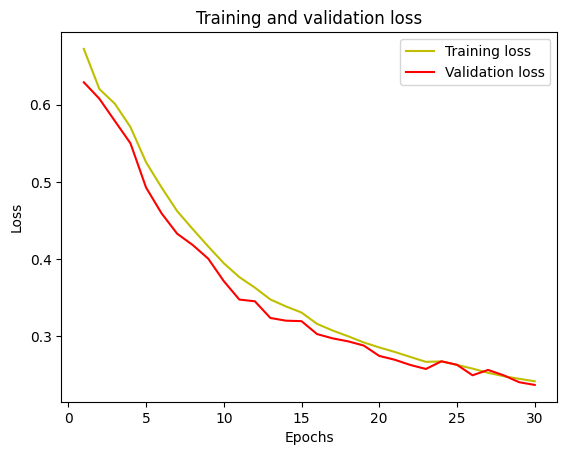

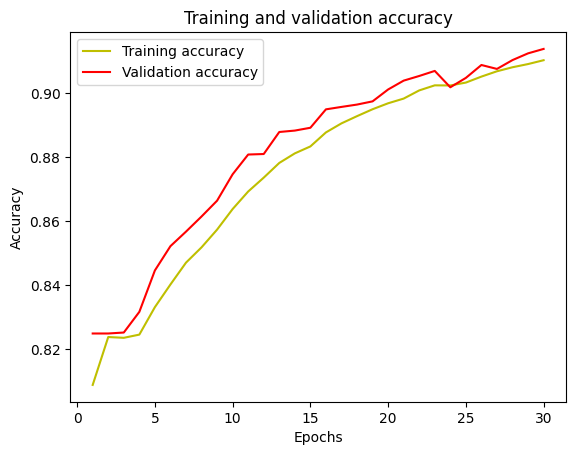

<Figure size 640x480 with 0 Axes>

In [8]:
def visualize(epochs, scores_1, scores_2, legend_1, legend_2, x_label, y_label, title, filename):
    plt.plot(epochs, scores_1, 'y', label=legend_1)
    plt.plot(epochs, scores_2, 'r', label=legend_2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    plt.savefig('../graphs/' + filename)
    

loss, val_loss, acc, val_acc = read_output(option_csv=True)
epochs = range(1, len(loss) + 1)
visualize(epochs, loss, val_loss, 'Training loss', 'Validation loss', 'Epochs', 'Loss', 'Training and validation loss', 'unet_sandstone_loss_30_ce.png')
visualize(epochs, acc, val_acc, 'Training accuracy', 'Validation accuracy', 'Epochs', 'Accuracy', 'Training and validation accuracy', 'unet_sandstone_acc_30_ce.png')

### **4. Run inference**

In [93]:
loaded_model = load_model('../models/unet_sandstone_30_ce_inp.hdf5')
output_test = loaded_model.predict(test_ds)
output_test.shape

13/13 [==============================] - 0s 16ms/step


(26, 256, 256, 4)

In [94]:
loss, acc = loaded_model.evaluate(test_ds)
print(loss, acc)

13/13 [==============================] - 1s 27ms/step - loss: 0.2354 - accuracy: 0.9145
0.23541425168514252 0.9145026803016663


### **5. Whole pipeline for prediction**

1/1 [==============================] - 0s 139ms/step


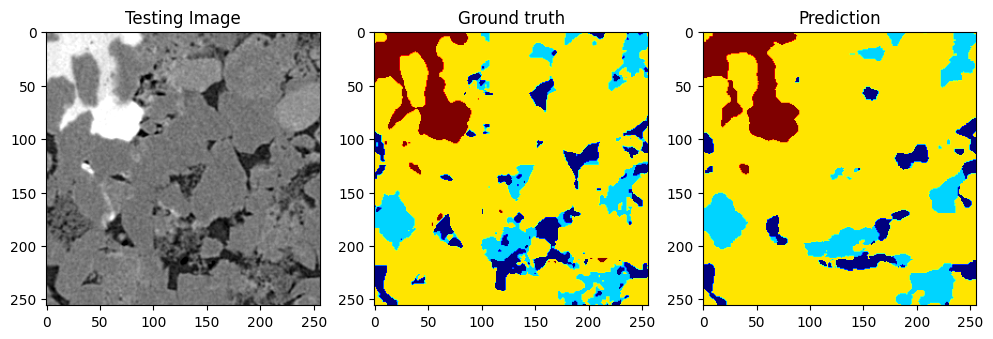

1/1 [==============================] - 0s 21ms/step


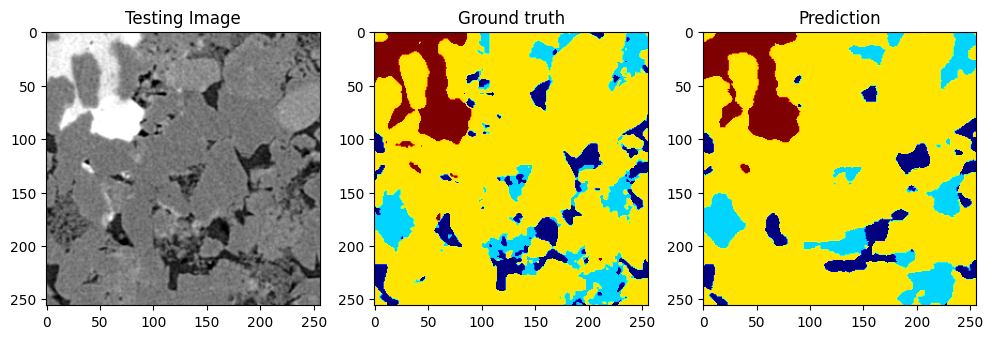

1/1 [==============================] - 0s 18ms/step


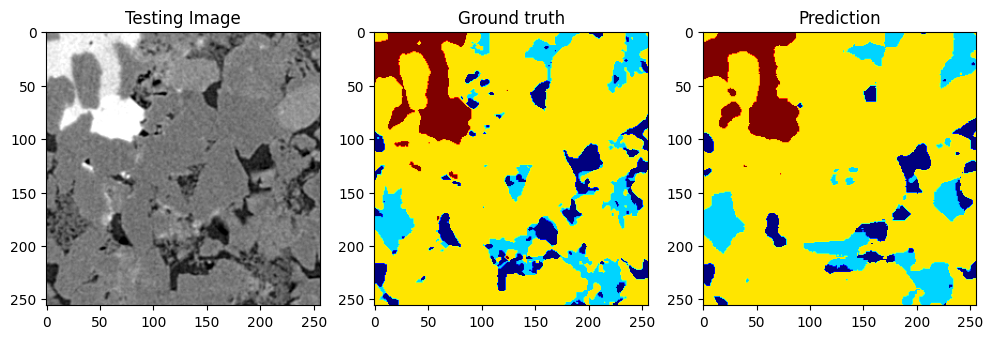

1/1 [==============================] - 0s 25ms/step


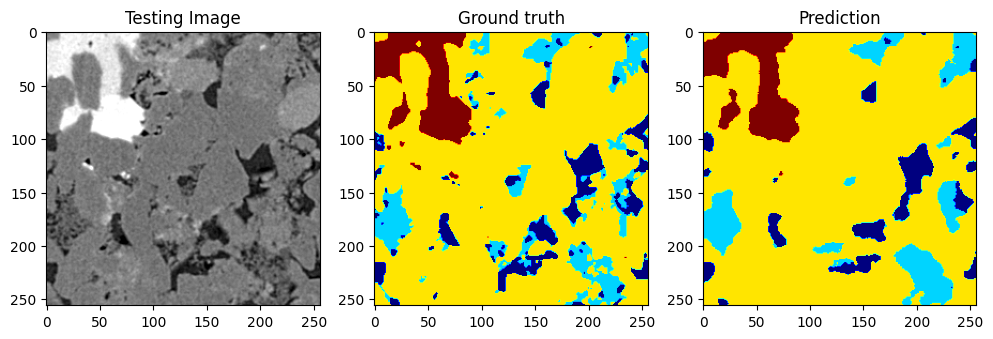

1/1 [==============================] - 0s 18ms/step


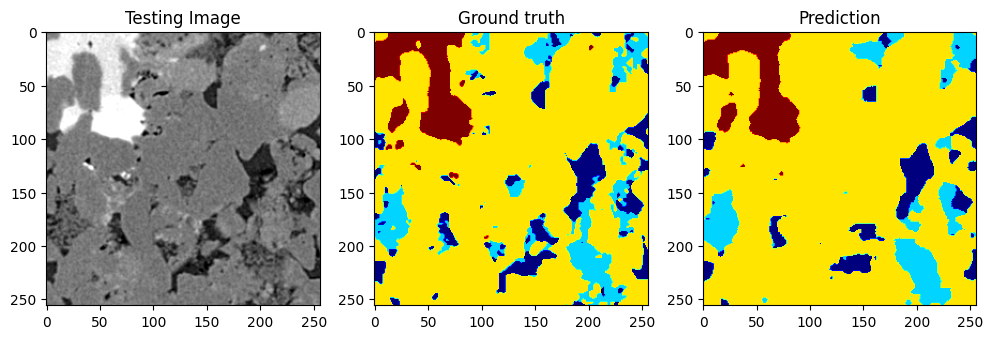

1/1 [==============================] - 0s 21ms/step


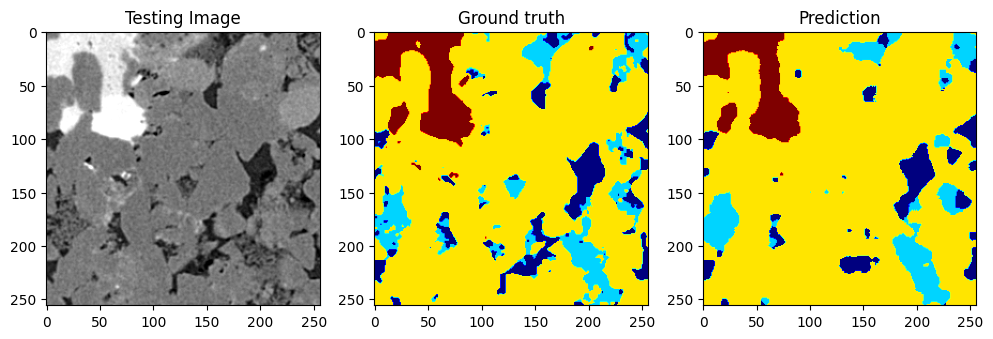

1/1 [==============================] - 0s 26ms/step


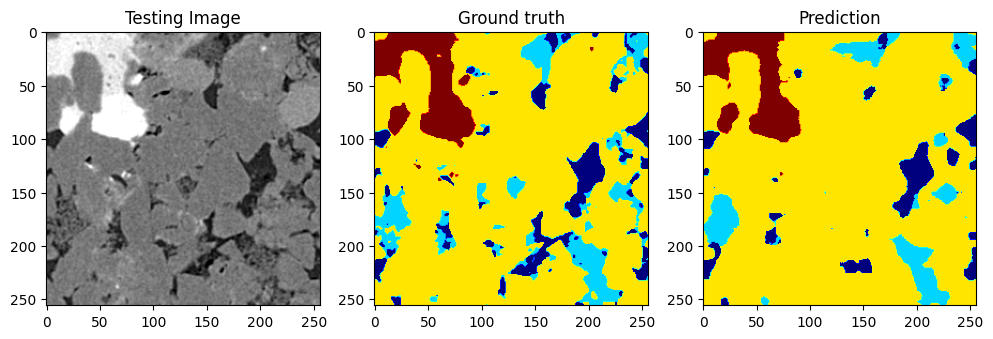

1/1 [==============================] - 0s 23ms/step


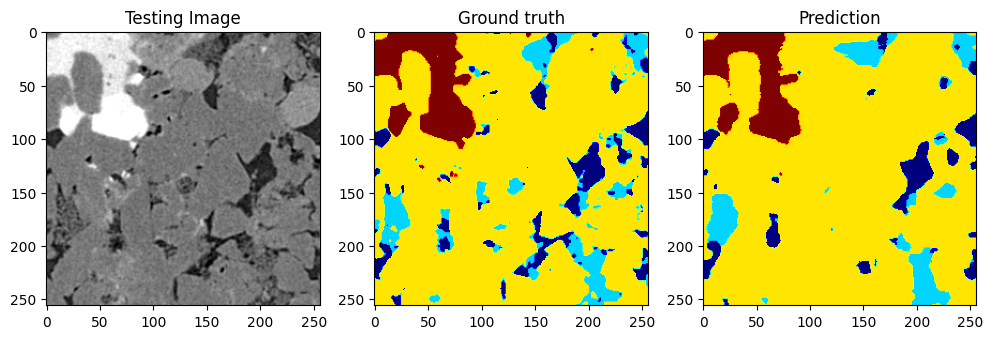

1/1 [==============================] - 0s 19ms/step


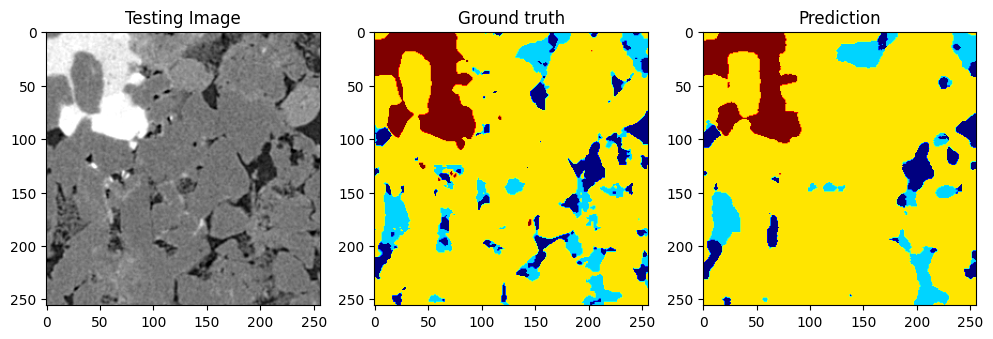

1/1 [==============================] - 0s 23ms/step


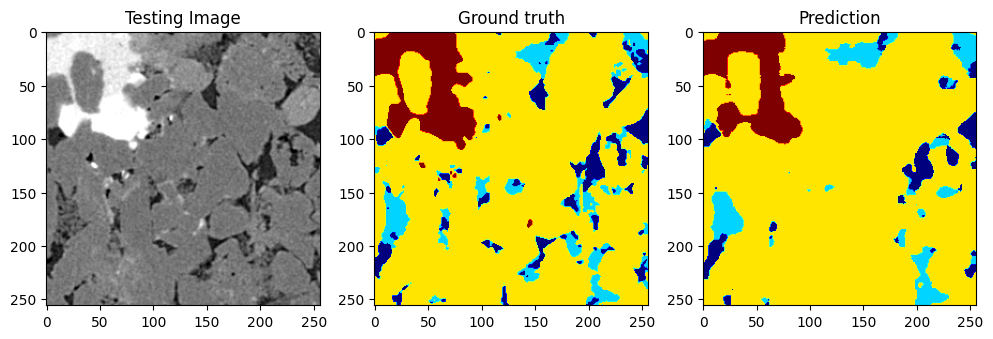

In [126]:
# 3D volume --> 2D slice image --> patches --> prediction --> next slice
def patching(image):
    image = image / 255.0
    image = np.repeat(np.expand_dims(image, axis=-1), 3, axis=-1)
    patch_shape = (cf["p"], cf["p"], cf["c"])                     
    patches = patchify(image, patch_shape, cf["p"])                         
    patches = np.reshape(patches, cf["flat_p_shape"]).astype(np.float32)   
    return np.expand_dims(patches, axis=0)
    
def run(model, path_vol, path_mask_vol, iteration=10):
    vol = tiff.imread(path_vol)
    mask_vol = tiff.imread(path_mask_vol)

    for index in range(iteration):
        image = patching(vol[index])
        pred = model.predict(image)
        pred = np.argmax(pred, axis=3)

        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(vol[index,:,:], cmap='gray')
        plt.subplot(232)
        plt.title('Ground truth')
        plt.imshow(mask_vol[index], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction')
        plt.imshow(pred[0,:,:], cmap='jet')
        plt.show()
    
run(
    model=load_model('../models/unet_sandstone_30_ce_inp.hdf5'),
    path_vol='../data/Sandstone/original/data_for_3D_Unet/train_images_256_256_256.tif',
    path_mask_vol='../data/Sandstone/original/data_for_3D_Unet/train_masks_256_256_256.tif'
)